<a href="https://colab.research.google.com/github/yueqiu2/Evolutionary_Algorithms/blob/main/CMA_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement learning for Control 🐶

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/07_RL_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

```{attention}
In this tutorial we are going to use the same CSTR example as in [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html). Therefore, it is a great idea to first look at tutorial 6 to have the complete context.
```



## A quick reminder ✅

Reinforcement Learning (RL) is an area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward.

RL algorithms are particularly well suited to address sequential decision making problems under uncertainty, for example, they are generally applied to solve problems in a Markov decision process (MDP) setting. A control problem (just like reactor control) is a sequential decision making problem under uncertainty, where at every time-step the controller (agent in the RL context) must take an optimal (control) action, and it is hindered by process disturbances (uncertainty). There are many types of reinforcement leanring algorithms, in this notebook tutorial we will focus on **policy optimization** algorithms.

We can define an RL agent as a controller that given a state ${\bf x}$ outputs the optimal action ${\bf u}$

$${\bf u}:=\pi({\bf x})$$

If the controller $\pi(\cdot)$ is parametrized, say by neural network weights $\boldsymbol{\theta}$, we can write

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

where ${\bf \theta}$ are parameters determined *a priori*. We could define the PID controller in this same fashion:

$$u:=\text{PID}(x;K_P,K_I,K_D)$$

In many cases, to fullfil the exploration - exploitation dilemma or in games, stochastic policies are used, which instead of outputting a single action ${\bf u}$, output a distributions over actions $p({\bf x};\boldsymbol{\theta})$.

$${\bf u} \sim p({\bf x};\boldsymbol{\theta})$$

In practice, it is common to have a neural network output the moments (mean and variance), and to then draw an action from the distribution parametrized by this mean and variance

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := p({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$

You can find a Taxonomy of RL Algorithms below.

```{figure} media/07_RL/algorithms.PNG
:alt: kNN
:width: 100%
:align: center

A broad classification of reinforcement learning algorithms. [source](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)
```

In [1]:
import torch
import torch.nn.functional as Ffunctional
import copy
import numpy as np

from scipy.integrate import odeint
from scipy.linalg import sqrtm
from scipy.stats import chi

import matplotlib.pyplot as plt
from pylab import grid
import time

The code below corresponds to the CSTR model and parameters of tutorial 6.

In [2]:
#@title CSTR code from tutorial 6

eps  = np.finfo(float).eps

###############
#  CSTR model #
###############

# ...For each step
def cstr(x,t,u):

    # == Control == #
    Tc  = u   # Temperature of cooling jacket (K)

    # == States == #
    Ca = x[0] # Concentration of A in CSTR (mol/m^3)
    T  = x[1] # Temperature in CSTR (K)

    # == Parameters == #
    Tf     = 350    # Feed temperature (K)
    q      = 100    # Volumetric Flowrate (m^3/sec)
    Caf    = 1      # Feed Concentration (mol/m^3)
    V      = 100    # Volume of CSTR (m^3)
    rho    = 1000   # Density of A-B Mixture (kg/m^3)
    Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
    mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
    EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0     = 7.2e10 # Pre-exponential factor (1/sec)
    UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)

    # == DAE System == #
    rA     = k0*np.exp(-EoverR/T)*Ca # reaction rate
    dCadt  = q/V*(Caf - Ca) - rA     # Calculate concentration derivative
    dTdt   = q/V*(Tf - T) \
              + mdelH/(rho*Cp)*rA \
              + UA/V/rho/Cp*(Tc-T)   # Calculate temperature derivative

    # == Dif Var == #
    xdot    = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt

    # Dif for each step
    return xdot


# Data collection

data_res = {}

# Initial state [CA, T]
x0             = np.zeros(2)
x0[0]          = 0.87725294608097
x0[1]          = 324.475443431599
data_res['x0'] = x0

# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# State & Control - Store results for plotting
Ca = np.zeros(len(t));      Ca[0]  = x0[0]
T  = np.zeros(len(t));      T[0]   = x0[1]
Tc = np.zeros(len(t)-1);

data_res['Ca_dat'] = copy.deepcopy(Ca)
data_res['T_dat']  = copy.deepcopy(T)
data_res['Tc_dat'] = copy.deepcopy(Tc)

# noise level
noise             = 0.1
data_res['noise'] = noise

# Control bounds
data_res['Tc_ub']  = 305
data_res['Tc_lb']  = 295
Tc_ub              = data_res['Tc_ub']
Tc_lb              = data_res['Tc_lb']

# State set point
n_1                = int(n/2)
n_2                = n - n_1
Ca_des             = [0.8 for i in range(n_1)] + [0.9 for i in range(n_2)]
T_des              = [330 for i in range(n_1)] + [320 for i in range(n_2)]
data_res['Ca_des'] = Ca_des
data_res['T_des']  = T_des

In [3]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(Ca_dat, T_dat, Tc_dat, data_simulation):

    Ca_des = data_simulation['Ca_des']
    T_des = data_simulation['T_des']

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    plt.plot(t, np.median(Ca_dat,axis=1), 'r-', lw=3)
    plt.gca().fill_between(t, np.min(Ca_dat,axis=1), np.max(Ca_dat,axis=1),
                           color='r', alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,2)
    plt.plot(t, np.median(T_dat,axis=1), 'c-', lw=3)
    plt.gca().fill_between(t, np.min(T_dat,axis=1), np.max(T_dat,axis=1),
                           color='c', alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,3)
    plt.step(t[1:], np.median(Tc_dat,axis=1), 'b--', lw=3)
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t']
    Ca_train = np.array(data_simulation['Ca_train'])
    T_train = np.array(data_simulation['T_train'])
    Tc_train = np.array(data_simulation['Tc_train'])
    Ca_des   = data_simulation['Ca_des']
    T_des    = data_simulation['T_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    for run_i in range(repetitions):
        plt.plot(t, Ca_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.title('Training plots')
    plt.ylim([.75, .95])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,2)
    for run_i in range(repetitions):
        plt.plot(t, T_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.ylim([335, 317])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,3)
    for run_i in range(repetitions):
        plt.step(t[1:], Tc_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))
    grid(True)

    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None:
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

## CMA-ES 🎲

### Policy network

First, let's create a neural network in PyTorch that has two hidden layers, one being double the size of the input layer and the other double the size of the output layer. We will use the activation functions [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) and [ReLU6](https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html). If you want a more gentle introduction to neural nets in Pytorch, check the [tutorial notebook 4](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html).

In [4]:
##################
# Policy Network #
##################

class Net(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
  def __init__(self, **kwargs):
    super(Net, self).__init__()

    self.dtype    = torch.float

    # Unpack the dictionary
    self.args     = kwargs

    # Get info of machine
    self.use_cuda = torch.cuda.is_available()
    self.device   = torch.device("cpu")

    # Define ANN topology
    self.input_size = self.args['input_size']
    self.output_sz  = self.args['output_size']
    self.hs1        = self.input_size*2
    self.hs2        = self.output_sz*2

    # Define layers
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    self.output  = torch.nn.Linear(self.hs2, self.output_sz)

  def forward(self, x):
    #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
    x = x.view(1, 1, -1).float()
    y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
    y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
    y = Ffunctional.relu6(self.output(y))   # range (0,6)

    return y

We normalize the inputs and states

In [5]:
# normalization for states and actions ????
data_res['x_norm'] = np.array([[.8, 315,0, 0],[.1, 10,.1, 20]]) # [mean],[range]
data_res['u_norm'] = np.array([[10/6],[295]])                   # [range/6],[bias]

**Sampling for CMA-ES**  
1. The samples are dictionary!!!
2. np.random.multivariate_normal: step size is inside the covariance matrix_





**Evaluate: Obj for CMA-ES**  
1. Load data and parameters.
2. Initialize state variables and data structures.
3. Simulate the CSTR system for whole episode.
   - Compute the control action based on the chosen control algorithm.
   - Simulate the system and update the states.
   - Add process disturbances to the system.
4. Tracking error
5. Collect data
6. Compute obj


In [6]:
def Single_NNparam(params_prev, mean_vec, step_size, cov):

  '''
  The mean, step size, cov are from previous iteration!
  '''

  # incorporating step size with the covariance matrix
  cov_ = np.multiply(step_size**2, cov)

  # sampling: for all NN parameters
  new_param_vec = np.random.multivariate_normal(mean_vec, cov_)

  # dictionary for NN params
  NNparams_CMAES = {}

  i = 0
  for k, v in params_prev.items():
    # CREATE NEW TENSOR: torch.from_numpy()
    v_size = np.prod(v.shape)
    new_tensor = torch.from_numpy(new_param_vec[i:i+v_size].reshape(v.shape))
    # replace old tensor in the key with new tensor
    NNparams_CMAES[k] = new_tensor
    i = i + v_size

  return NNparams_CMAES

In [7]:
def J_PolicyCSTR(policy, data_res=data_res,
                 collect_training_data=True, traj=False, episode=False):

    # load data D
    Ca    = copy.deepcopy(data_res['Ca_dat'])
    T     = copy.deepcopy(data_res['T_dat'])
    Tc    = copy.deepcopy(data_res['Tc_dat'])
    t     = copy.deepcopy(data_res['t'])
    x0    = copy.deepcopy(data_res['x0'])
    noise = data_res['noise']

    # setpoints
    Ca_des = data_res['Ca_des']; T_des = data_res['T_des']

    # upper and lower bounds
    Tc_ub  = data_res['Tc_ub'];  Tc_lb  = data_res['Tc_lb']

    # normalized states and actions
    x_norm = data_res['x_norm']; u_norm = data_res['u_norm'];

    # initiate
    x         = x0
    e_history = []

    # Simulate CSTR for the whole episode
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([Ca_des[i],T_des[i]])

        # Simulate CSTR
        # Input of the NN is [states + setpoints!]
        xk      = np.hstack((x,x_sp-x))
        # state preprocesing
        xknorm       = (xk-x_norm[0])/x_norm[1]
        xknorm_torch = torch.tensor(xknorm)
        # compute u_k from policy
        mean_uk      = policy(xknorm_torch).detach().numpy()
        u_k          = np.reshape(mean_uk, (1, 1))
        u_k          = u_k*u_norm[0] + u_norm[1]
        u_k          = u_k[0]
        u_k          = min(max(u_k, Tc_lb), Tc_ub)
        Tc[i]        = u_k[0]
        # ----------------------------------------------------------------

        # simulate system
        y            = odeint(cstr,x,ts,args=(Tc[i],))
        # add process disturbance
        s            = np.random.uniform(low=-1, high=1, size=2)
        Ca[i+1]      = y[-1][0] + noise*s[0]*0.1
        T[i+1]       = y[-1][1] + noise*s[1]*5
        # state update
        x[0]         = Ca[i+1]
        x[1]         = T[i+1]
        # compute tracking error
        e_history.append((x_sp-x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/0.2+np.abs(np.array(e_history)[:,1])/15
    # penalize magnitud of control action
    u_mag = np.abs(Tc[:]-Tc_lb)/10
    u_mag = u_mag/10
    # penalize change in control action
    u_cha = np.abs(Tc[1:]-Tc[0:-1])/10
    u_cha = u_cha/10

    # collect data for plots
    if collect_training_data:
        data_res['Ca_train'].append(Ca)
        data_res['T_train'].append(T)
        data_res['Tc_train'].append(Tc)
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)

    # sums: combine errors for both states
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if traj:
      return Ca, T, Tc
    else:
      return error + u_mag + u_cha

**Epoch Run**

In [8]:
def flatten_params(params):

  # extract params from the params dictionary -> generate several arrays in a big list
  flattened_params = [value.detach().numpy().flatten() for value in params.values()]
  # combine it in an array: flatten the arrays to 1D,
  flattened_params = np.concatenate(flattened_params)

  return flattened_params

In [9]:
def unflatten_params(vec, dict):

  # dictionary for policy
  policy = {}

  j = 0
  for k, v in dict.items():
    # CREATE TENSOR: torch.from_numpy()
    v_size = np.prod(v.shape)
    new_tensor = torch.from_numpy(vec[j:j+v_size].reshape(v.shape))
    # replace old tensor in the key with new tensor
    policy[k] = new_tensor
    j = j + v_size

  return policy

In [10]:
#@title
# Trial - flatten
nu        = 1
nx        = 2
hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
n_steps   = data_res['n']

policy_net = Net(**hyparams)
params     = policy_net.state_dict()

# Trial
mean_vec = np.zeros(61)
step_size = 0.1
cov = np.eye(61)

param = Single_NNparam(params, mean_vec, step_size, cov)

flatten_params(param)

unflatten_params(mean_vec, params)

{'hidden1.weight': tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]], dtype=torch.float64),
 'hidden1.bias': tensor([0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64),
 'hidden2.weight': tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64),
 'hidden2.bias': tensor([0., 0.], dtype=torch.float64),
 'output.weight': tensor([[0., 0.]], dtype=torch.float64),
 'output.bias': tensor([0.], dtype=torch.float64)}

In [11]:
def epoch_run(params_prev, mean_vec, step_size, cov, no_epis):

  # record date for one epoch
  params_epoch = []
  errors_epoch = []

  # single -> epoch
  for i in range(no_epis):
    # initialization
    policy_net = Net(**hyparams)
    # sample single NN param
    new_single_param = Single_NNparam(params_prev, mean_vec, step_size, cov)
    # load it
    policy_net.load_state_dict(new_single_param)
    # evaluate
    new_error = J_PolicyCSTR(policy_net, collect_training_data=True)

    # flatten the param vector for calculating the mean
    new_single_param = flatten_params(new_single_param)

    # record
    params_epoch.append(new_single_param)
    errors_epoch.append(new_error)

  params_epoch = np.array(params_epoch)
  errors_epoch = np.array(errors_epoch)

  return params_epoch, errors_epoch

**Select Elite Group & Update**
0. Select
1. Mean
2. Step size
3. Cov

In [12]:
# 0. select
def elite_group_epoch(params_epo, errors_epo, elite_size):

  assert len(params_epo) == len(errors_epo) > 0

  # select the elite group: by picking the smallest errors, top 50%
  no_elite = np.ceil(elite_size).astype(int)
  # get the indexes
  elite_indices = np.argsort(errors_epo)[:no_elite]

  # get the corresponding elite params
  elite_params = params_epo[elite_indices]
  elite_errors = errors_epo[elite_indices]

  return elite_params, elite_errors

In [ ]:
#@title
# Trial - run epoch + elite
nu        = 1
nx        = 2
hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
n_steps   = data_res['n']

policy_net = Net(**hyparams)
params_prev = policy_net.state_dict()

# Trial
mean_vec = np.zeros(61)
step_size = 0.1
cov = np.eye(61)
no_episodes = 20
elite_size = 10

# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = []
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

params_epoch, errors_epoch = epoch_run(params_prev, mean_vec, step_size, cov, no_episodes)
elite_params, elite_errors = elite_group_epoch(params_epoch, errors_epoch, elite_size)

In [13]:
# 1. mean
def mean_vec_update(mean_vec, lr_mean, elite_params):
  '''
  Input:
  mean_vec - from last epoch
  elite_params - from this epoch
  '''

  # make the input from the last epoch the previous one
  mean_vec_prev = mean_vec
  dif_mean = elite_params - mean_vec_prev
  # update new mean
  mean_vec = mean_vec_prev + lr_mean * np.mean(dif_mean, axis=0)

  # return both for evolution path of step size
  return mean_vec, mean_vec_prev

In [ ]:
#@title
# Trial - mean

mean_vec_prev = np.zeros(61)
lr_mean = 0.1
mean_vec, mean_vec_prev = mean_vec_update(mean_vec_prev, lr_mean, elite_params)

In [14]:
# 2. step size

def ss_update(lr_ss, dp, mean_vec, mean_vec_prev,
              ep_ss, ss, cov, elite_size):
  '''
  sequence should be correct!

  lr_ss, dp: learning rate & damping factor
  mean_vec / mean_vec_prev: from update mean function

  ep_ss: evolution path from last epoch
  ss   : step size from last epoch
  cov  : cov from last epoch

  elite_errors
  '''

  # change the status from last epoch to the previous one
  ep_ss_prev = ep_ss
  ss_prev    = ss
  cov_prev   = cov

  # ENSURE THAT THE COV IS POSITIVE FINITE!!!
  cov_prev = cov_prev + np.eye(cov_prev.shape[0]) * 1e-8

  # inverse square root covariance matrix
  sqrt_cov_matrix = sqrtm(cov_prev)  # square root
  inv_sqrt_cov = np.linalg.inv(sqrt_cov_matrix)  # inverse

  # dif term (make sure denominator is not 0!!!)
  y_w = (mean_vec - mean_vec_prev) / (ss_prev + 1e-8)

  a = (1 - lr_ss) * ep_ss_prev
  b = np.sqrt(lr_ss * (2 - lr_ss) * elite_size)
  c = np.dot(inv_sqrt_cov, y_w)

  # update evolution path of step size
  ep_ss = (1 - lr_ss) * ep_ss_prev + \
          np.sqrt(lr_ss * (2 - lr_ss) * elite_size) * \
          np.dot(inv_sqrt_cov, y_w)

  # expected length for random selection
  n = mean_vec.size
  expected_l = chi(n).mean()

  # update step size
  ss = ss_prev * np.exp(lr_ss/dp * (np.linalg.norm(ep_ss)/expected_l - 1))

  return ss, ep_ss

In [15]:
#@title
# Trial - step size

lr_ss = 0.1
dp = 1
ep_ss_prev = np.zeros(61)
cov_prev = cov
ss_prev = 2

ss_update(lr_ss, dp, mean_vec, mean_vec_prev, ep_ss_prev, ss_prev, cov_prev, elite_errors)

NameError: ignored

In [16]:
# 3. cov

def cov_update(lr_cp, lr_c1, lr_cmin,
               mean_vec, mean_vec_prev,
               ss,
               ep_c, cov,
               elite_params,
               elite_size):

  '''
  ss: step size from last epoch
  ep_c: evolution path from last epoch
  cov: cov matrix from last epoch
  '''

  ss_prev = ss
  ep_c_prev = ep_c
  cov_prev = cov

  # rank one - evolution path
  y_w = (mean_vec - mean_vec_prev) / (ss_prev + 1e-8)
  ep_c = (1 - lr_cp) * ep_c_prev + np.sqrt(lr_cp * (2 - lr_cp) * elite_size) * y_w

  # rank min - new matrix
  # normalized yi for all elite params
  yis = (elite_params - mean_vec_prev) / (ss_prev + 1e-8)
  # one matrix for each elite params, store all in yi_covs
  yi_covs = np.array([np.outer(yi, yi) for yi in yis])
  # calculate average
  average_yi_cov = np.sum(yi_covs, axis=0) / elite_size

  # update covariance matrix
  cov = (1 - lr_c1 - lr_cmin) * cov_prev + \
        lr_c1 * np.outer(ep_c, ep_c.T) + \
        lr_cmin * average_yi_cov

  return cov, ep_c

In [ ]:
#@title
# Trial - cov

lr_cp = 0.5
lr_c1 = 0.3
lr_cmin = 0.2

ep_c_prev = np.ones(61)
cov_prev = np.eye(61)

cov, ep_c = cov_update(lr_cp, lr_c1, lr_cmin,
            mean_vec, mean_vec_prev,
            ss_prev,
            ep_c_prev, cov_prev,
            elite_params,
            elite_errors)

ValueError: ignored

**CMA-ES for Policy Update**

In [17]:
# RL
def CMA_ES_policy_search(lr_mean, lr_ss, lr_cp, lr_c1, lr_cmin, dp,
                         epo, epis, elite_size):

  # recording
  mean_list = []
  error_list = []

  # initialization - network
  nu        = 1
  nx        = 2
  hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
  n_steps   = data_res['n']

  # initialization - random params
  policy_net = Net(**hyparams)
  params     = policy_net.state_dict()

  if policy_net.use_cuda:
    policy_net = policy_net.to(policy_net.device)

  # initialization - mean, step size, cov
  mean_vec = flatten_params(params)  # flatten the params dict
  dim = mean_vec.size                # size of params
  ss = 5
  cov = np.eye(dim)                  # identity matrix

  # initialization - evolution path
  ep_ss = np.zeros(dim)
  ep_c = np.zeros(dim)

  termination_condition = False

  # iteration
  for gen in range(epo):

    # ======== sample ======= #
    # run one epoch
    params_epoch, errors_epoch = epoch_run(params, mean_vec, ss, cov, epis)
    # select elite group
    elite_params, elite_errors = elite_group_epoch(params_epoch, errors_epoch, elite_size)

    # ======== update ======= #
    # 1. update mean
    mean_vec, mean_vec_prev = mean_vec_update(mean_vec, lr_mean, elite_params)
    # 2. update step size
    ss, ep_ss = ss_update(lr_ss, dp,
                          mean_vec, mean_vec_prev,
                          ep_ss, ss, cov,
                          elite_size)
    # 3. update covariance matrix
    cov, ep_c = cov_update(lr_cp, lr_c1, lr_cmin,
                          mean_vec, mean_vec_prev,
                          ss,
                          ep_c, cov,
                          elite_params,
                          elite_size)

    print(np.mean(elite_errors))

    mean_list.append(mean_vec)
    error_list.append(np.mean(elite_errors))

    # termination condition
    if np.mean(elite_errors) < 23:
      termination_condition = True
    if termination_condition:
      break

  # ======== select the best ======== #
  best_index  = np.nanargmin(error_list)  # want to ingore the nan

  # get the best policy, unflatten vector to dictionary
  best_policy = mean_list[best_index]
  dict_struc = policy_net.state_dict()
  best_policy = unflatten_params(best_policy, dict_struc)

  # lowest error
  best_error = error_list[best_index]

  print(best_index)
  print(best_policy)
  print(best_error)

  return best_policy, best_error

**This is the illustration for one training -> best policy**

68.0516523359633
69.37040251233887
63.474713954533996
79.94444346984085
40.273215088195485
39.50078658263971
37.51123116603374
40.920432173019925
61.84701314468564
54.25581663068838
38.60730304017105
35.0182098502315
73.9373773190347
78.90099764688276
65.03366662213854
38.902396793018454
33.009606570810305
31.153611867930053
34.168332804133144
46.0731596958899
50.87006953307319
41.14381852850107
39.58741975592663
32.95266442232307
32.803128261359994
34.54878635374692
32.021185625227986
31.72059649561044
28.754022616892314
30.413307860775504
31.991927745892795
28.0810770145949
28.780422111479034
29.94961702374888
27.50558162593259
30.308322698824576
32.132717609983025
30.75798385554401
27.574843865747184
27.907855849882917
27.191720276287995
28.090047646889488
28.90896815569839
29.58722912784696
28.583267804775037
28.573566627327192
27.83524065831088
26.80659901183123
28.181900600815293
29.17141454603392
30.21295079162099
28.406607503875144
27.921541264738856
27.130513112642646
28.28324

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Run terminated (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


27.47800581526418
26.913946035606394
27.169828150964477
28.294142608402105
28.989951553363
44.228842629818395
nan
62
{'hidden1.weight': tensor([[-7.9814e+12,  2.0659e+12, -2.9499e+12, -2.1190e+12],
        [-1.3749e+13,  5.3723e+12,  4.4750e+12, -7.2537e+12],
        [-1.1253e+12, -7.0616e+11,  9.5440e+12, -4.3384e+12],
        [ 4.1108e+12,  1.1256e+12,  1.5082e+13, -1.1526e+13],
        [ 2.2253e+12, -8.4165e+12,  9.5931e+12,  1.5119e+12],
        [ 1.3807e+12, -3.2116e+11,  4.0187e+12, -6.1937e+12],
        [ 3.7407e+12,  6.4512e+11, -7.1536e+12,  4.3053e+12],
        [-4.3760e+12, -3.4804e+12,  4.2092e+12,  3.8880e+12]],
       dtype=torch.float64), 'hidden1.bias': tensor([-1.7729e+13, -3.4984e+12,  2.7647e+12,  4.2419e+11, -3.0079e+12,
        -1.6189e+11, -1.6082e+12, -6.1155e+12], dtype=torch.float64), 'hidden2.weight': tensor([[ 4.4758e+12,  5.6139e+10,  1.0907e+12,  1.2725e+13,  6.3642e+12,
          7.7318e+11, -3.6480e+12,  1.3413e+13],
        [ 2.4596e+12,  4.2662e+12,  2.

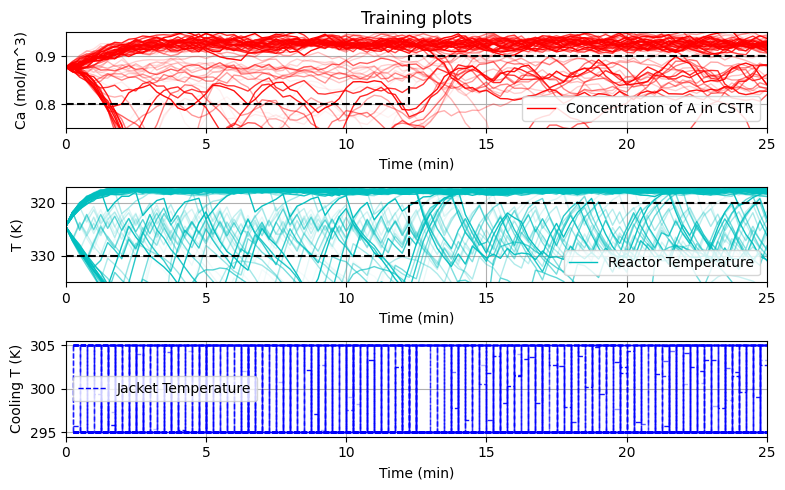

In [18]:
#@title

# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = []
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

lr_mean = 3
lr_ss = 0.2
lr_cp = 0.05
lr_c1 = 0.005
lr_cmin = 0.03
dp = 1

epo = 70
epis = 15 # 4+3*ln(61)
elite_size = 4


best_policy, best_error = CMA_ES_policy_search(lr_mean, lr_ss, lr_cp, lr_c1, lr_cmin, dp,
                         epo, epis, elite_size)

plot_training(data_res, epo)

Notice that the 'input size' below has an extra +2. This is because we must pass the information to the policy network about the setpoint (given that our setpoint will change). Therefore, we give 2 extra inputs to our policy network, one for each setpoint.

**This is the illustration of the best policy!**

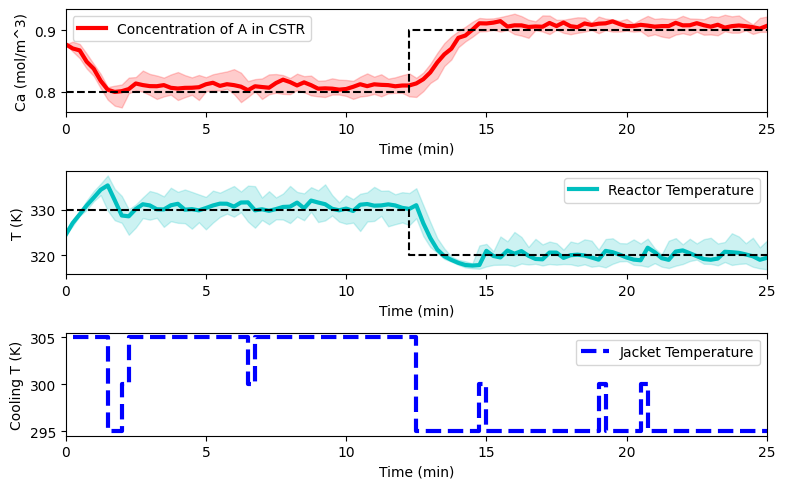

In [19]:
nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
policy_net_CMAES = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_CMAES.load_state_dict(best_policy)

reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(policy_net_CMAES,
                                                                collect_training_data=False,
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

#### Date: 5/7 ~ 7/7
### Summary

- Error will stuck at 27 at current best choice of hyperparameters

### Question:
- Local optima?  
if: how to get out of it?
- On NN it mentioned with linear structure the performance is not expected to be good?
- Hyperparameter tuning?
- Choice of activation function?

### Further:
- HP tuning, activation function
- Improve the sampling? Multiple shooting?
- Combine PG do transfer learning


## Policy Gradients 🗻

Policy gradient methods rely on the [Policy Gradient Theorem](https://link.springer.com/article/10.1007/BF00992696) which allows to retrieve the gradient of the expected objective function with respect to policy parameters (neural network weights) $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ through Monte Carlo runs. Given the availability of gradients, it is possible to follow a gradient-based optimization to optimize the policy, generally, Adam or Gradient Descent is used. More information can be found of Chapter 13 on [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html).

In this tutorial notebook we outline the simplest algorithm of this kind, **Reinforce**. For a more in dept introduction to the topic see [Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

In the case of stochastic policies, the policy function returns the defining parameters of a probability distribution (such as the mean and variance) over possible actions, from which the actions are sampled:
$$\textbf{u} \sim \pi_\theta(\textbf{u} | \textbf{x}) = \pi(\textbf{u} | \textbf{x}, \theta) = p(\textbf{u} | \textbf{x}, \theta)$$

Note*: this is the same as the stochastic policy introduced earlier, following the 'probability notation'.

To learn the optimal policy, we seek to maximize our performance metric, and hence we can follow a gradient ascent strategy:
$$\theta_{m+1} = \theta_m + \alpha_m \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] $$

where $m$ is the current iteration that the parameters are updated (epoch), $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ is the expectation of $f$ over $\pi_\theta$ and $\alpha_m$ is the step size (also termed learning rate in the RL community) for the $m^{th}$ iteration.

Computing $ \nabla_\theta \hat{f}(\theta) = \nabla_\theta\mathbb{E}_{\pi_\theta}[J(\pi_\theta)]$ directly is difficult, therefore we use the Policy Gradient Theorem, which shows the following:


$$ \begin{alignat}{3}
\nabla_\theta\hat{f}(\theta) = \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] &~=~\nabla_\theta \int  p(\pi_\theta|\theta)~ f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\int \nabla_\theta p(\pi_\theta|\theta)~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \frac{\nabla_\theta p(\pi_\theta|\theta)}{p(\pi_\theta|\theta)~} ~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right]
\end{alignat} $$

Notice from the first expression, that, $p(\pi_\theta|\theta)~ f(\pi_\theta)$ is an objective function value multiplied by its probability density, therefore, integrating this over all possible values of $\pi_\theta$ we obtain the expected value. From there, using simple algebra, logarithms and the chain rule, we arrive at the final equations, which shows an expected value, where, dropping the explicit distribution of $\pi_\theta$, gives us an unbiased gradient estimator, our steepest ascent update now becomes:

$$ \theta_{m+1} = \theta_m + \alpha_m \mathbb{E}_{\pi_\theta}\left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right]
$$

Using the expression for $p(\pi_\theta|\theta) = \hat{\mu}(\textbf{x}_0) \prod_{t=0}^{T-1} \left[\pi(\textbf{u}_t|\textbf{x}_t,\theta) p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t) \right]$ and taking its logarithm, we obtain:

$$\nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) = \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)$$

Note that since $p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t)$ and $\hat{\mu}(\textbf{x}_0)$ are independent of $\theta$ they disappear from the above expression. Then we can rewrite for a trajectory as:

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] = \mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right]$$

The above expression does not require the knowledge of the dynamics of the physical system. Monte-Carlo method is utilized to approximate the expectation.

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] \approx \frac{1}{K} \sum_{k=1}^{K} \left( f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right)$$


**Reinforce algorithm**

${\bf Input:}$ Initialize policy parameter $\theta = \theta_0$, with $\theta_0\in\Theta_0$, learning rate $\alpha$, set number of episodes $K$ and number of epochs $N$.

${\bf Output:}$ policy $\pi(\cdot | \cdot ,\theta)$ and $\Theta$
\smallskip

#### **(This is the plain gradient without FIM...)**

${\bf for}$ $m = 1,\dots, N$ ${\bf do}$


1.   Collect $\textbf{u}_t^k , \textbf{x}_t^k,f(\pi_\theta^k)$ for $K$ trajectories of $T$ time steps.
2.   Estimate the gradient $ \hat{g}_m := \frac{1}{K} \sum_{k=1}^{K}  \left[ f(\pi_\theta^k) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t^k|\hat{\textbf{x}}_t^k,\theta)\right)\right]$
3.   Update the policy using a policy gradient estimate $\theta_{m+1} = \theta_m + \alpha_m \hat{g}_m$
4.   $m:=m+1$

${\bf Remark}$: The above algorithm is the base version for many further developments that have been made since it was first proposed.

The steps of the algorithm are explained below:

${\bf Initialization:}$ The policy network and its weights $\theta$ are initialized along with the algorithm's hyperparameters such as learning rate, number of episodes and number of epochs.

${\bf Training ~~ loop:}$ The weights of the policy network are updated by a policy gradient scheme for a total of $N$ epochs.

In ${\bf Step 1}$ $K$ trajectories are computed, each trajectory consists of $T$ time steps, and states and control actions are collected.

In ${\bf Step 2}$ the gradient of the objective function with respect to the weights for the policy network is computed.

In ${\bf Step 3}$ the weights of the policy network are updated by a gradient ascent scheme. Note that here we show a steepest ascent-like update, but other first order (i.e. Adam) or trust region methods can be used (i.e. PPO, TRPO).

In ${\bf Step 4}$, either the algorithm terminates or returns to Step 1.

In [20]:
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.distributions import MultivariateNormal

In order to implement and apply the Reinforce algorithm, we are going to perform the following steps in the following subsections:


*   Create a [policy network](#policy_net) that uses transfer learning
*   Create an auxiliary function that selects [control actions](#control_actions) out of the distribution
*   Create an auxilary function that runs [multiple episodes](#multi_episodes) per epoch
*   Finally, put all the pieces together into a function that computes the [Reinforce algorithm](#r_alg)



<a name="policy_net"></a>
### Policy network


In the next section of this tutorial notebook we show an implementation from scratch of a policy optimization algorithm using policy gradients.

Given that we have already optimized the policy via stochastic search in the previous section, **we use those parameters as a starting point for policy gradients.** This is a form of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning#:~:text=Transfer%20learning%20(TL)%20is%20a,when%20trying%20to%20recognize%20trucks.), which refers to applying knowledge that was previously gained while solving one task to a related task.

Related to this transfer learning process, we will create a second neural network with the exact same configuration as before, but we will **add an extra node to each output of the original neural network to account for the variance term**. This is because previously our neural network policy had the structure:

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and by a Stochastic search algorithm we manipulated the weights $\boldsymbol{\theta}$ to optimize performance. In policy gradients we output a distribution, rathen than a single value, in this case we output the mean and the variance of a normal distribution (each output now has two values, the mean and the variance), and therefore we must add an extra node to each output such that we have:

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := \pi({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$



**NN + Transfer learning [Not investigated in this CMA-ES file]**  
In transfer learning add another output as variance

In [21]:
#########################################
# Policy Network with transfer learning #
#########################################

class Net_TL(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
  def __init__(self, **kwargs):
    super(Net_TL, self).__init__()

    self.dtype    = torch.float

    # Unpack the dictionary
    self.args     = kwargs

    # Get info of machine
    self.use_cuda = torch.cuda.is_available()
    self.device   = torch.device("cpu")

    # Define ANN topology
    self.input_size = self.args['input_size']
    self.output_sz  = self.args['output_size']
    self.hs1        = self.input_size*2
    self.hs2        = self.output_sz*2

    # Define layers
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    self.output  = torch.nn.Linear(self.hs2, self.output_sz)

  def forward(self, x):
    #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
    x = x.view(1, 1, -1).float()
    y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
    y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
    y = Ffunctional.relu6(self.output(y))   # range (0,6)

    return y

  # Transfer learning
  def increaseClassifier(self, m:torch.nn.Linear):
    w         = m.weight
    b         = m.bias
    old_shape = m.weight.shape

    m2        = nn.Linear( old_shape[1], old_shape[0] + 1)  # +1 for variance term
    m2.weight = nn.parameter.Parameter( torch.cat( (m.weight, m2.weight[0:1]) ),
                                       requires_grad=True )
    m2.bias   = nn.parameter.Parameter( torch.cat( (m.bias, m2.bias[0:1]) ),
                                       requires_grad=True)
    return m2

  def incrHere(self):
    self.output = self.increaseClassifier(self.output)

Notice that just as before, we ad a +2 to the input, as thisrefers to the current set-point value.

In [22]:
nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2

policy_net_pg = Net_TL(**hyparams, requires_grad=True, retain_graph=True)
policy_net_pg.load_state_dict(best_policy) # Transfer learning
policy_net_pg.incrHere()

<a name="control_actions"></a>
### Control action selection


In [23]:
################################
# action selection from Normal #
################################

def select_action(control_mean, control_sigma):
    """
    Sample control actions from the distribution their distribution
    input: Mean, Variance
    Output: Controls, log_probability, entropy
    """
    s_cov          = control_sigma.diag()**2                  # Multi-distribution / Covariance
    dist           = MultivariateNormal(control_mean, s_cov)  # Generate the control space
    control_choice = dist.sample()                            # Sampling
    log_prob       = dist.log_prob(control_choice)            # Compute log prob of this action (how likely or unlikely)

    entropy        = dist.entropy()                           # Compute the entropy of the distribution N(mu, std)

    return control_choice, log_prob, entropy

#########################
# un-normalizing action #
#########################

# Scaling back from N~(0,1) to N(μ,σ)
def mean_std(m, s, mean_range=[10], mean_lb=[295], std_range=[0.001]):
    '''
    Problem specific restrictions on predicted mean and standard deviation.
    '''
    mean = Tensor(mean_range) * m/6 + Tensor(mean_lb) # ReLU6
    std  = Tensor(std_range)  * s/6

    return mean, std

<a name="multi_episodes"></a>
### Multiple episodes - one epoc/training step


Q: Baseline what for?

In [24]:
################
# one epoc run #
################

def epoc_run(NNpolicy, episodes_n):
    '''This function runs episodes_n episodes and collected the data. This data
    is then used for one gradient descent step.

    INPUTS
    NNpolicy:   the NN policy
    episodes_n: number of episodes per epoc (gradient descent steps)
    data_train: dictionary of data collected

    OUTPUTS
    data_train: collected data to be passed to the main training loop
    '''

    # run episodes
    logprobs_list = [] # log probabilities is the policies itself p(a|s)
    reward_list   = [] # reward
    for epi_i in range(episodes_n):
        reward_, sum_logprob = J_PolicyCSTR(NNpolicy, policy_alg='PG_RL',
                                            collect_training_data=True, episode=True)
        logprobs_list.append(sum_logprob)
        reward_list.append(reward_)

    # compute mean and expectation of rewards
    reward_m   = np.mean(reward_list)
    reward_std = np.std(reward_list)


    # compute the baseline (reverse sum)
    log_prob_R = 0.0
    for epi_i in reversed(range(episodes_n)):
        baselined_reward = (reward_list[epi_i] - reward_m) / (reward_std + eps)
        log_prob_R       = log_prob_R - logprobs_list[epi_i] * baselined_reward

    # mean log probability
    mean_logprob = log_prob_R/episodes_n
    reward_std   = reward_std
    reward_m     = reward_m

    return mean_logprob, reward_std, reward_m

<a name="r_alg"></a>
### Reinforce algorithm

Now, let's create a function that put all pieces together and implements the Reinforce algorithm explained above

In [25]:
def Reinforce(policy, optimizer, n_epochs, n_episodes):

    # lists for plots
    rewards_m_record = []; rewards_std_record = []

    for epoch_i in range(n_epochs):

        # collect data
        mean_logprob, reward_std, reward_m = epoc_run(policy, n_episodes)

        # Expected log reward
        E_log_R = mean_logprob
        # Clear the gradient from previous iteration
        optimizer.zero_grad()
        # Back propogation to calculate gradient
        E_log_R.backward()
        # Update parameter
        optimizer.step()

        # save data for analysis
        rewards_m_record.append(reward_m)
        rewards_std_record.append(reward_std)

        # schedule to reduce lr
        scheduler.step(E_log_R)

        if epoch_i%int(n_epochs/10)==0:
            mean_r = reward_m
            std_r  = reward_std
            print('epoch:', epoch_i)
            print(f'mean reward: {mean_r:.3} +- {std_r:.2}')

    return rewards_m_record, rewards_std_record, policy

### Apply the Reinforce algorithm

Now that we have the algorithm, let's apply it to the problem.

Let's choose some problem parameters and initialize storing lists

In [26]:
# problem parameters
lr         = 0.0001
total_it   = 2000
n_episodes = 50
n_epochs   = int(total_it/n_episodes)

# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = []
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

define the policy and the optimizer to be used

In [27]:
# define policy and optimizer
control_policy = policy_net_pg
optimizer_pol  = optim.Adam(control_policy.parameters(), lr=lr)

define the learning rate scheduler

In [28]:
# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pol, factor=0.5, patience=10, verbose=True, min_lr=0.000001,
    cooldown = 10)

and apply the algorithm

```{note} Runing the algorithm will last for a few minutes
```

In [ ]:
rewards_m_record, rewards_std_record, optimal_Reinforce = \
Reinforce(control_policy, optimizer_pol, n_epochs, n_episodes)

Let's visualize now

In [ ]:
# plot the samples of posteriors
plt.plot(rewards_m_record, 'black', linewidth=1)
# plot GP confidence intervals
iterations = [i for i in range(len(rewards_m_record))]
plt.gca().fill_between(iterations, np.array(rewards_m_record) - 3*np.array(rewards_std_record),
                       np.array(rewards_m_record) + 3*np.array(rewards_std_record),
                       color='C0', alpha=0.2)
plt.title('RL Reward')
plt.legend(('mean', 'conf interval'),
           loc='lower right')
plt.show()

In [ ]:
plot_training(data_res, e_tot)

In [ ]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(policy_net_pg,
                                                               policy_alg='PG_RL',
                                                                collect_training_data=False,
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

## Extra material on RL for ChemEng 🤓

If you would like to read more about the use of reinforcement learning in chemical engineering systems:

**Applications**

*   Reinforcement learning offers potential for bringing significant improvements to [industrial batch process control practice](https://www.sciencedirect.com/science/article/abs/pii/S136757882100081X) even in [discontinous and nonlinear systems](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168).
*   RL has also been used to address [chemical production scheduling](https://www.sciencedirect.com/science/article/pii/S0098135420301599) and [multi-echelon supply chains](https://www.sciencedirect.com/science/article/pii/S2772508122000643)
*   Other applications include [PID tuning](https://www.sciencedirect.com/science/article/abs/pii/S0967066121002963), [real-time optimization](https://www.mdpi.com/2227-9717/11/1/123), [searching for optimal process routes](https://www.sciencedirect.com/science/article/abs/pii/S0098135420303999), [flowsheet generation](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17938), [bioreactors](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168) and [biotherapeutics](https://onlinelibrary.wiley.com/doi/10.1002/bit.28346), amongst many others.

**Methodologies**

*   Constraints to address [plant-model mismatch](https://www.sciencedirect.com/science/article/abs/pii/S0098135421004087), [constrained Q-learning](https://www.sciencedirect.com/science/article/abs/pii/S0098135421002404), [safe reinforcement learning](https://www.researchgate.net/publication/368302457_Safe_deployment_of_reinforcement_learning_using_deterministic_optimization_of_trained_neural_networks), satisfaction of constraints with [high probability](https://www.sciencedirect.com/science/article/pii/S0959152422000038), and [dynamic penalties](https://www.sciencedirect.com/science/article/pii/S0959152422000816) for better convergence.
*   [Process control](https://www.mdpi.com/2227-9717/10/11/2311), [meta-reinforcement learning](https://www.sciencedirect.com/science/article/pii/S0959152422001445), [general economic process control](https://www.sciencedirect.com/science/article/pii/S0098135420307912), amongst many many others.

